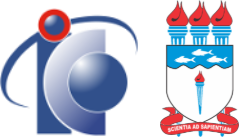

> ## **UNIVERSIDADE FEDERAL DE ALAGOAS - UFAL**
> ### **INSTITUTO DE COMPUTAÇÃO - IC**
> #### Nome: **Bruno Lemos de Lima** &emsp;&emsp;&emsp;&emsp;&nbsp;&nbsp; **|**&emsp;&emsp; Matrícula: **19110935**
> #### Nome: **Karla Sophia Santana da Cruz**&emsp;&nbsp; **|**&emsp;&emsp; Matrícula: **19111113**
> #### Curso: **Engenharia de Computação** &emsp;&emsp; **|** &emsp;&emsp;Período: **2023.1**

> # **Processamento de Linguagem Natural - Thales Vieira**
> # **Lista 3**




#### requirements

In [ ]:
import io
import ast
import nltk
import spacy
import requests
import pandas as pd
import numpy as np
import gensim.downloader as api
import matplotlib.pyplot as plt

In [ ]:
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### dataset movies_genre

In [ ]:
parquet_url = 'https://github.com/karlasophiacruz/nlp-2023.1/raw/main/dataset/movie_genre_pre_processed.parquet'
parquet_content = requests.get(parquet_url).content
parquet_file = io.BytesIO(parquet_content)

In [ ]:
df = pd.read_parquet(parquet_file)
df = df.drop(columns='column0')
df.head()

,id,class,text,original_text,vectors,stemmed
0,38401,fantasy,monster high welcome monster high dracula m...,Monster High: Welcome to Monster High: When Dr...,"[2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['monst', 'high', 'welcom', 'monst', 'high', '..."
1,44720,fantasy,yanka el espíritu del volcán year old girl...,Yanka y el espíritu del volcán: A 13 year old ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","['yank', 'el', 'espíritu', 'del', 'volcán', 'y..."
2,38032,fantasy,xia qing du meng fei fresh kung fu training...,You xia qing: Du Meng Fei fresh out of Kung-Fu...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","['xia', 'qing', 'du', 'meng', 'fei', 'fresh', ..."
3,40538,fantasy,beast bodmin moor nicholas felt jacob crims...,The Beast of Bodmin Moor: Nicholas Felt and Ja...,"[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['beast', 'bodmin', 'moor', 'nichola', 'felt',..."
4,38634,fantasy,captain yagit street scum becomes leader,Captain Yagit: A STREET SCUM BECOMES A LEADER.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","['captain', 'yagit', 'street', 'scum', 'becom'..."


In [ ]:
print(df['stemmed'])

0       ['monst', 'high', 'welcom', 'monst', 'high', '...
1       ['yank', 'el', 'espíritu', 'del', 'volcán', 'y...
2       ['xia', 'qing', 'du', 'meng', 'fei', 'fresh', ...
3       ['beast', 'bodmin', 'moor', 'nichola', 'felt',...
4       ['captain', 'yagit', 'street', 'scum', 'becom'...
                              ...                        
9995    ['myst', 'riv', 'liv', 'three', 'men', 'child'...
9996    ['devil', 'night', 'devil', 'night', 'chronicl...
9997    ['body', 'grav', 'defy', 'kil', 'wom', 'sydney...
9998    ['burnout', 'group', 'teen', 'head', 'ret', 'c...
9999    ['die', 'die', 'delt', 'pi', 'new', 'chapt', '...
Name: stemmed, Length: 10000, dtype: object


#### utils

In [ ]:
def list_to_str(list):
  list_str = []

  for item in list:
    line = item.strip('[]').replace("'", "").split(", ")
    string = ' '.join(line)
    list_str.append(string)

  return list_str

def stemmer(text):
  stemmer = LancasterStemmer()
  tokens = word_tokenize(text)
  stemmed_tokens = [stemmer.stem(token) for token in tokens]

  return stemmed_tokens

In [ ]:
list_str = list_to_str(df['stemmed'])
list_token = [word_tokenize(text) for text in list_str]

> ### Usando sua base de textos após os pré-processamentos realizados na lista 1, realize as seguintes tarefas:

### **1.** O objetivo dessa questão é desenvolver buscadores de palavras e documentos.

#### **a)** escolha e aplique um modelo do tipo word2vec a seus textos, compatível com o idioma de seus textos (inglês ou português).

In [ ]:
dataset_model = Word2Vec(list_token)
dataset_model.save("word2vec_model")

In [ ]:
info = api.info()
global_model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


#### **b)** escolha 5 palavras de consulta que não estejam em nenhum dos textos. Para cada palavra de consulta, encontre as 3 palavras de seu conjunto de textos mais parecidas com cada uma das palavras de consulta e exiba os documentos onde estas palavras aparecem.

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

X = tfidf_vectorizer.fit_transform(list_str)
text_words = tfidf_vectorizer.get_feature_names_out()

In [ ]:
words = ['wallet', 'cake', 'panda', 'shield', 'rockstar']

for word in words:
  try:
    vector = dataset_model.wv[stemmer(word)]
  except KeyError:
    print(f"A palavra {word} não está no dicionário.")

A palavra wallet não está no dicionário.
A palavra cake não está no dicionário.
A palavra panda não está no dicionário.
A palavra shield não está no dicionário.
A palavra rockstar não está no dicionário.


In [ ]:
for query_word in words:
  print("--------------------------------------------------------------------------------------------------------------------------------\n")
  similar_words = []

  if query_word in global_model:
    for word in text_words:
      try:
          similarity = global_model.similarity(query_word, word)
          similar_words.append((word, similarity))

      except KeyError:
        continue

    similar_words.sort(key=lambda x: x[1], reverse=True)
    similar_words_dataset = similar_words[:3]

    print(f"3 palavras mais semelhantes a '{query_word}':", str(similar_words_dataset).strip('[]'))

    all_similar_texts = []
    for word, similarity in similar_words_dataset:
        similar_words_texts = [text_word for text_word in list_str if word in text_word.split()]
        all_similar_texts.extend(similar_words_texts)
    similar_texts_words = list(set(all_similar_texts))

    print("Quantidade de documentos que possuem as palavras semelhantes:", len(similar_texts_words), "\n")

    for word, similarity in similar_words_dataset:
      text = [text for text in similar_texts_words if word in text]
      print(f"Documento que contém a palavra {word}:", text[0])
    print()

--------------------------------------------------------------------------------------------------------------------------------

3 palavras mais semelhantes a 'wallet': ('bag', 0.8930803), ('pocket', 0.8708356), ('seat', 0.867576)
Quantidade de documentos que possuem as palavras semelhantes: 22 

Documento que contém a palavra bag: kick head redmond spirit quest nyc unc sam giv bag del friend stretch bring middl shoot out good angst meet cut stewardess
Documento que contém a palavra pocket: virt low budget budget movy mad empty pocket writ diret christian ackerm com littl independ scif act comedy adv movy extrav ep heart
Documento que contém a palavra seat: psycho list jacky brick obsess bird prey becom ser kil glob pandem claim victim bicyc seat

--------------------------------------------------------------------------------------------------------------------------------

3 palavras mais semelhantes a 'cake': ('cream', 0.9556342), ('breakfast', 0.90033615), ('snack', 0.8970992)
Qua

#### **c)** Seja d um documento da base e w uma palavra de consulta. Implemente o seguinte algoritmo para buscar documentos:

1. Encontre $d_{10}(w)$: a lista com as 10 palavras mais parecidas com $w$ em um certo documento $d$.
2. Para cada documento $d$, calcule a distância média $DM_{10}(w)$ entre w e
as palavras de $d_{10}(w)$.
3. Recupere os 3 documentos da base cuja $DM_{10}(w)$ é menor.

In [ ]:
def d10(w, d):
  similar_words_doc = []

  words = d.split()
  words = list(set(words))

  w_vector = global_model[w] if w in global_model else None
  if w_vector is None:
    print(f"Palavra {w} não está presente no modelo.")
    return None

  for word in words:
    try:
        similarity = global_model.similarity(w, word)
        similar_words_doc.append((word, similarity))

    except KeyError:
      # print(f"Palavra {word} não está presente no Modelo.")
      continue

  topn = 10
  if len(similar_words_doc) < 10:
    topn = len(similar_words_doc)
    # print(f"Documento possui apenas {topn} palavras similares.")

  similar_words_doc.sort(key=lambda x: x[1], reverse=True)
  top_n_similar_words = similar_words_doc[:topn]

  return top_n_similar_words

def dm10(w, d):
  d10_words = d10(w, d)

  if not d10_words:
    return np.inf

  similarities = [d10_word[1] for d10_word in d10_words]

  return 1 - np.mean(similarities)

def minor_dm10(w):
  dm10_all_d = []

  for d in list_str:
    dm10_all_d.append(dm10(w, d))

  dm10_sorted = sorted(enumerate(dm10_all_d), key=lambda x: x[1])
  minor_dm_3_d = dm10_sorted[:3]

  return minor_dm_3_d

#### **d)** aplique o algoritmo da letra c) para buscar documentos em 5 palavras distintas, e exiba os 3 documentos mais próximos de cada um.

In [ ]:
for word in words:
  print(f"---------------------------------------------------------------------------------------------------------------------------\nPalavra {word}\n")
  near_3_docs_word = minor_dm10(word)

  for i, (index, distance) in enumerate(near_3_docs_word):
    print(f"Documento {i}: {list_str[index]}\nDistância: {distance}\n")

---------------------------------------------------------------------------------------------------------------------------
Palavra wallet

Documento 0: got stuck new jersey end fight army zomby contamin yellow pencil infect smal town high school standard test day mismatch group teen must band togeth hard drink chain smok shop teach ord surv army rag infect
Distância: 0.30791956186294556

Documento 1: spy harmony secret ag ferguson memb as sent miss americ find philip kern cross dress arm deal attempt buy yellow cak u team am secret ag francesc balbon togeth work complet miss
Distância: 0.3315585255622864

Documento 2: wool pair eld junk collect find liv turn upsid latest proc bring contact obsess young knit hallucinog feat debut promin short filmmak mai tominag
Distância: 0.3415980339050293

---------------------------------------------------------------------------------------------------------------------------
Palavra cake

Documento 0: bab yag ter dark forest eg mom die get stepmo

### **2.** Resolva novamente a primeira questão da 2a lista e compare com os resultados obtidos anteriormente:

O problema será determinar se a sinopse de um filme pertence ao gênero "fantasia" ou não. Vamos considerar dois rótulos: "fantasy" para sinopses que pertencem a este gênero e "not_fantasy" para sinopses que não pertencem a este gênero. Para isso iremos duplicar a tabela de dados, pois não queremos alterar a tabela original. A nova tabela será chamada de "df_question_2".

In [ ]:
df_question_2 = df.copy()

Além disso, se faz necessário transformamos os arrays da columa "stemmed" em strings separadas por espaço.

In [ ]:
df_question_2['stemmed_str'] = df_question_2['stemmed'].apply(lambda x: ' '.join(ast.literal_eval(x)))

Após realizar a cópia, iremos determinar o rótulo para dividir o dataframe em duas classes, sendo elas: "fantasy" (valor igual a "1") para determinar as sinopses de filmes de fantasia e "not_fantasy" (valor igual a "0") para determinar as sinopses de filmes que não são de fantasia.

In [ ]:
df_question_2['binary_class'] = df['class'].apply(lambda x: 1 if x == 'fantasy' else 0)

In [ ]:
df_question_2.head()

,id,class,text,original_text,vectors,stemmed,stemmed_str,binary_class
0,38401,fantasy,monster high welcome monster high dracula m...,Monster High: Welcome to Monster High: When Dr...,"[2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['monst', 'high', 'welcom', 'monst', 'high', '...",monst high welcom monst high dracul meet frank...,1
1,44720,fantasy,yanka el espíritu del volcán year old girl...,Yanka y el espíritu del volcán: A 13 year old ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","['yank', 'el', 'espíritu', 'del', 'volcán', 'y...",yank el espíritu del volcán year old girl nam ...,1
2,38032,fantasy,xia qing du meng fei fresh kung fu training...,You xia qing: Du Meng Fei fresh out of Kung-Fu...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","['xia', 'qing', 'du', 'meng', 'fei', 'fresh', ...",xia qing du meng fei fresh kung fu train find ...,1
3,40538,fantasy,beast bodmin moor nicholas felt jacob crims...,The Beast of Bodmin Moor: Nicholas Felt and Ja...,"[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['beast', 'bodmin', 'moor', 'nichola', 'felt',...",beast bodmin moor nichola felt jacob crimsby h...,1
4,38634,fantasy,captain yagit street scum becomes leader,Captain Yagit: A STREET SCUM BECOMES A LEADER.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","['captain', 'yagit', 'street', 'scum', 'becom'...",captain yagit street scum becom lead,1


Divisão em conjuntos de treino e teste (70% treino e 30% teste).

In [ ]:
X = df_question_2['stemmed_str']
y = df_question_2['binary_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### **a)** Aplicando a representação vetorial Doc2Vec combinado com os classificadores usados anteriormente.

Agora vamos preparar os dados para treinar um modelo Doc2Vec, convertendo as sinopses de filmes em representações vetoriais de 100 dimensões. Cada sinopse é associada a um índice único. O modelo aprende a capturar informações contextuais e semânticas. Após isso, podemos dividir os dados para treino e teste.

In [ ]:
documents = [TaggedDocument(words=ast.literal_eval(doc), tags=[i]) for i, doc in enumerate(df_question_2['stemmed'])]
doc2vec_model = Doc2Vec(vector_size=100, min_count=2, epochs=100)

In [ ]:
doc2vec_model.build_vocab(documents)

In [ ]:
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [ ]:
X_train_doc2vec, X_test_doc2vec, y_train_doc2vec, y_test_doc2vec = train_test_split(doc2vec_model.dv.vectors, df_question_2['binary_class'], test_size=0.3, random_state=42)

##### Logistic Regression:

In [ ]:
logistic_regression = LogisticRegression()

logistic_regression.fit(X_train_doc2vec, y_train_doc2vec)

y_pred_logistic_regression = logistic_regression.predict(X_test_doc2vec)

In [ ]:
print("Metrics for Logistic Regression:\n")

print("Confusion Matrix:", confusion_matrix(y_test_doc2vec, y_pred_logistic_regression))
print("Accuracy:", accuracy_score(y_test_doc2vec, y_pred_logistic_regression))
print("Precision:", precision_score(y_test_doc2vec, y_pred_logistic_regression, pos_label=1))
print("Recall:", recall_score(y_test_doc2vec, y_pred_logistic_regression, pos_label=1))
print("F1 Score:", f1_score(y_test_doc2vec, y_pred_logistic_regression, pos_label=1))

Metrics for Logistic Regression:

Confusion Matrix: [[2667   15]
 [ 306   12]]
Accuracy: 0.893
Precision: 0.4444444444444444
Recall: 0.03773584905660377
F1 Score: 0.06956521739130435


##### Naive Bayes:

In [ ]:
naive_bayes = GaussianNB()

naive_bayes.fit(X_train_doc2vec, y_train_doc2vec)

y_pred_naive_bayes = naive_bayes.predict(X_test_doc2vec)

In [ ]:
print("Metrics for Naive Bayes:\n")

print("Confusion Matrix:", confusion_matrix(y_test_doc2vec, y_pred_naive_bayes))
print("Accuracy:", accuracy_score(y_test_doc2vec, y_pred_naive_bayes))
print("Precision:", precision_score(y_test_doc2vec, y_pred_naive_bayes, pos_label=1))
print("Recall:", recall_score(y_test_doc2vec, y_pred_naive_bayes, pos_label=1))
print("F1 Score:", f1_score(y_test_doc2vec, y_pred_naive_bayes, pos_label=1))

Metrics for Naive Bayes:

Confusion Matrix: [[2591   91]
 [ 268   50]]
Accuracy: 0.8803333333333333
Precision: 0.3546099290780142
Recall: 0.15723270440251572
F1 Score: 0.21786492374727667


##### SVM (Linear Kernel):

In [ ]:
svm = SVC(kernel='linear', C=1.0, class_weight='balanced')

svm.fit(X_train_doc2vec, y_train_doc2vec)

y_pred_svm = svm.predict(X_test_doc2vec)

In [ ]:
print("Metrics for SVM:\n")

print("Confusion Matrix:", confusion_matrix(y_test_doc2vec, y_pred_svm))
print("Accuracy:", accuracy_score(y_test_doc2vec, y_pred_svm))
print("Precision:", precision_score(y_test_doc2vec, y_pred_svm, pos_label=1))
print("Recall:", recall_score(y_test_doc2vec, y_pred_svm, pos_label=1))
print("F1 Score:", f1_score(y_test_doc2vec, y_pred_svm, pos_label=1))

Metrics for SVM:

Confusion Matrix: [[1802  880]
 [ 110  208]]
Accuracy: 0.67
Precision: 0.19117647058823528
Recall: 0.6540880503144654
F1 Score: 0.2958748221906116


#### **b)** Usando pelo menos duas arquiteturas de redes neurais que utilizem camadas Embedding, convolucionais e LSTM.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

In [ ]:
model_cnn_lstm = keras.Sequential()

model_cnn_lstm.add(layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=100))
model_cnn_lstm.add(layers.Conv1D(128, 5, activation='relu'))
model_cnn_lstm.add(layers.MaxPooling1D(2))
model_cnn_lstm.add(layers.LSTM(100))
model_cnn_lstm.add(layers.Dense(1, activation='sigmoid'))

model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=32)

y_pred_cnn_lstm = (model_cnn_lstm.predict(X_test_pad) > 0.5).astype(int)

Epoch 1/5
219/219 [==============================] - 31s 90ms/step - loss: 0.3242 - accuracy: 0.9000
Epoch 2/5
219/219 [==============================] - 5s 25ms/step - loss: 0.2002 - accuracy: 0.9201
Epoch 3/5
219/219 [==============================] - 3s 14ms/step - loss: 0.0690 - accuracy: 0.9760
Epoch 4/5
219/219 [==============================] - 4s 16ms/step - loss: 0.0124 - accuracy: 0.9969
Epoch 5/5
94/94 [==============================] - 1s 3ms/step


In [ ]:
print("Metrics for CNN-LSTM:\n")

print("Confusion Matrix:", confusion_matrix(y_test, y_pred_cnn_lstm))
print("Accuracy:", accuracy_score(y_test, y_pred_cnn_lstm))
print("Precision:", precision_score(y_test, y_pred_cnn_lstm, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_cnn_lstm, pos_label=1))
print("F1 Score:", f1_score(y_test, y_pred_cnn_lstm, pos_label=1))

Metrics for CNN-LSTM:

Confusion Matrix: [[2573  127]
 [ 251   49]]
Accuracy: 0.874
Precision: 0.2784090909090909
Recall: 0.16333333333333333
F1 Score: 0.20588235294117646


In [ ]:
model_dense = keras.Sequential()

model_dense.add(layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=100))
model_dense.add(layers.Flatten())
model_dense.add(layers.Dense(128, activation='relu'))
model_dense.add(layers.Dense(1, activation='sigmoid'))

model_dense.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_dense.fit(X_train_pad, y_train, epochs=5, batch_size=32)

y_pred_dense = (model_dense.predict(X_test_pad) > 0.5).astype(int)

Epoch 1/5
219/219 [==============================] - 16s 66ms/step - loss: 0.3267 - accuracy: 0.8979
Epoch 2/5
219/219 [==============================] - 4s 19ms/step - loss: 0.1274 - accuracy: 0.9480
Epoch 3/5
219/219 [==============================] - 2s 10ms/step - loss: 0.0095 - accuracy: 0.9990
Epoch 4/5
219/219 [==============================] - 2s 10ms/step - loss: 0.0016 - accuracy: 0.9999
Epoch 5/5
94/94 [==============================] - 0s 1ms/step


In [ ]:
print("Metrics for Dense NN:\n")

print("Confusion Matrix:", confusion_matrix(y_test, y_pred_dense))
print("Accuracy:", accuracy_score(y_test, y_pred_dense))
print("Precision:", precision_score(y_test, y_pred_dense, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_dense, pos_label=1))
print("F1 Score:", f1_score(y_test, y_pred_dense, pos_label=1))

Metrics for Dense NN:

Confusion Matrix: [[2674   26]
 [ 288   12]]
Accuracy: 0.8953333333333333
Precision: 0.3157894736842105
Recall: 0.04
F1 Score: 0.07100591715976332


### **3.** Usando sua base de textos, e se baseando no exemplo disponível em: https://keras.io/examples/generative/lstm_character_level_text_generation/

#### **a)** Treine uma rede LSTM para gerar texto a nível de caractere, que receba uma quantidade fixa de caracteres $Q$ como entrada. O treinamento deve ser realizado considerando um conjunto supervisionado que prevê o próximo caractere de uma sequência de tamanho $Q = 10$, usando sequências de sua base.

In [ ]:
text = " ".join(df['original_text'].to_list()).lower()
print("Corpus length:", len(text))

Corpus length: 1721369


In [ ]:
text

'monster high: welcome to monster high: when dracula meets frankie, they decide to create a school. but recruiting students always comes with its trials and tribulations. yanka y el espíritu del volcán: a 13 year old girl named yanka goes in the search for her mother whose been presumed dead in a dangerous forest. you xia qing: du meng fei fresh out of kung-fu training, finds himself caught up in a 20 year conflict between the evil thunder gang chief leng tian lei and the dragon sect. lei seeks his missing daughter and will kill anyone who gets in his way. the beast of bodmin moor: nicholas felt and jacob crimsby head to the moors of bodmin to uncover the mystery of the beast. captain yagit: a street scum becomes a leader. immortals: theseus is a mortal man chosen by zeus to lead the fight against the ruthless king hyperion, who is on a rampage across greece to obtain a weapon that can destroy humanity. quartier lointain: a grown man wakes up to discover he is a teenager again. tainá: 

In [ ]:
chars = sorted(list(set(text)))
print("Total chars:", len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Total chars: 104


In [ ]:
Q = 10
step = 1

sentences = []
next_chars = []

for i in range(0, len(text) - Q, step):
    sentences.append(text[i : i + Q])
    next_chars.append(text[i + Q])

print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), Q, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 1721359


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(Q, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
epochs = 20
batch_size = 128

model.fit(x, y, batch_size=batch_size, epochs=epochs)

Epoch 1/20
13449/13449 [==============================] - 71s 5ms/step - loss: 1.7187
Epoch 2/20
13449/13449 [==============================] - 63s 5ms/step - loss: 1.5519
Epoch 3/20
13449/13449 [==============================] - 63s 5ms/step - loss: 1.5209
Epoch 4/20
13449/13449 [==============================] - 63s 5ms/step - loss: 1.5052
Epoch 5/20
13449/13449 [==============================] - 64s 5ms/step - loss: 1.4968
Epoch 6/20
13449/13449 [==============================] - 64s 5ms/step - loss: 1.4918
Epoch 7/20
13449/13449 [==============================] - 64s 5ms/step - loss: 1.4884
Epoch 8/20
13449/13449 [==============================] - 64s 5ms/step - loss: 1.4869
Epoch 9/20
13449/13449 [==============================] - 64s 5ms/step - loss: 1.4856
Epoch 10/20
13449/13449 [==============================] - 65s 5ms/step - loss: 1.4854
Epoch 11/20
13449/13449 [==============================] - 64s 5ms/step - loss: 1.4873
Epoch 12/20
13449/13449 [===========================

#### **b)** Após o treinamento, exiba pelo menos 5 exemplos de textos dados de entrada, e do texto gerado em seguida pela rede treinada. Para cada exemplo, gere pelo menos 50 caracteres consecutivamente.

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature

    exp_preds = np.exp(preds)

    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)

    return np.argmax(probas)

def generate_text(seed_text, max_length=100, temperature=1.0):
    generated_text = seed_text
    model.reset_states()

    for _ in range(max_length):
        x_pred = np.zeros((1, len(seed_text), len(chars)))
        for t, char in enumerate(seed_text):
            x_pred[0, t, char_indices[char]] = 1.0

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = indices_char[next_index]

        generated_text += next_char
        seed_text = seed_text[1:] + next_char

    return generated_text

In [ ]:
for _ in range(5):
    print("---------------------------------------------------------------------------------------------------------------------------")

    start_index = np.random.randint(0, len(text) - Q - 1)
    seed_text = text[start_index : start_index + Q]

    generated_text = generate_text(seed_text)

    print("Texto de Entrada:", seed_text)
    print("Texto Gerado:", generated_text)

---------------------------------------------------------------------------------------------------------------------------


<ipython-input-42-c7ec9a3295d5>:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


Texto de Entrada: . snow: yo
Texto Gerado: . snow: york fembaptity witnesses. he building into a victory discover to leave to leave him law man: lover to
---------------------------------------------------------------------------------------------------------------------------
Texto de Entrada: p of young
Texto Gerado: p of young. the death for lorder -come tastiokest fellimo george and giolears about comenter is comedy and a s
---------------------------------------------------------------------------------------------------------------------------
Texto de Entrada: and evil. 
Texto Gerado: and evil. amen: a martially conceled fending murdering carce is a protect the grisbul hong kongdoutes and he m
---------------------------------------------------------------------------------------------------------------------------
Texto de Entrada: nity again
Texto Gerado: nity again of homeon a feudet gang expelicances. opic bying an unclj in a blured to bry adong), at peace commu
------------

### **4.** Usando sua base de textos e a biblioteca spaCy, realize as seguintes tarefas:

Primeiro precisamos duplicar a tabela de dados, pois não queremos alterar a tabela original. A nova tabela será chamada de "df_question_4".

In [ ]:
df_question_4 = df.copy()

In [ ]:
nlp = spacy.load('en_core_web_sm')

#### **a)** Extraia as etiquetas gramaticais (POS) de cada token do seu textos.

In [ ]:
df_question_4['pos_tags'] = df_question_4['text'].apply(lambda text: [token.pos_ for token in nlp(text)])

#### **b)** Calcule e plote um gráfico com as frequências de cada tipo gramatical.

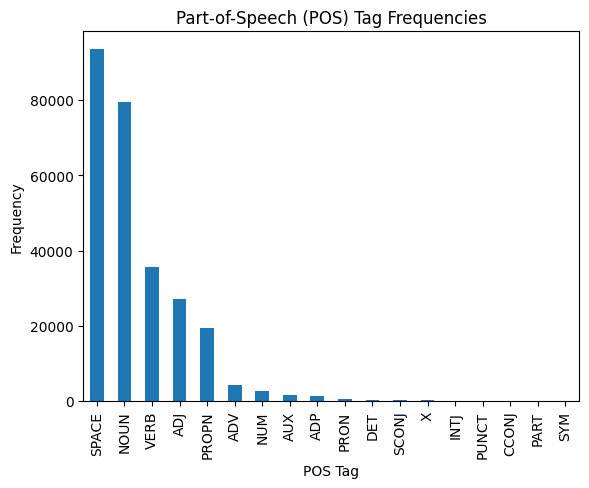

In [ ]:
pos_freq = [tag for tags in df_question_4['pos_tags'] for tag in tags]
pos_freq = pd.Series(pos_freq).value_counts()

pos_freq.plot(kind='bar')

plt.title("Part-of-Speech (POS) Tag Frequencies")

plt.xlabel("POS Tag")
plt.ylabel("Frequency")

plt.show()

#### **c)** Extraia entidades do tipo pessoa e lugar dos seus textos.

In [ ]:
df_question_4['entities'] = df_question_4['text'].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents if ent.label_ in ['PERSON', 'GPE']])

#### **d)** Identifique e liste as pessoas mais frequentes nos seus textos. Você só deve contar cada entidade 1 vez por documento.

In [ ]:
all_people = [entity for entities in df_question_4['entities'] for entity, label in entities if label == 'PERSON']

most_common_people = pd.Series(all_people).value_counts().head(10)

print("Most Frequent People in the Texts:")
for idx, (name, count) in enumerate(most_common_people.items(), 1):
    print(f"{idx}. {name}: {count} mentions")

Most Frequent People in the Texts:
1. jack: 25 mentions
2. wolf: 24 mentions
3. joe: 16 mentions
4. mike: 14 mentions
5. mummy: 12 mentions
6. arthur: 9 mentions
7. lone wolf: 9 mentions
8. paul: 9 mentions
9. max: 9 mentions
10. lucy: 8 mentions
